** Use my Kongu email for Run Fhis... File**

In [3]:
!pip install stanza
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 31.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import stanza
import nltk
from sklearn.utils import resample

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

stanza.download('ta')  # Tamil model
nlp = stanza.Pipeline('ta', processors='tokenize')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ta (Tamil) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ta/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ta (Tamil):
| Processor | Package |
-----------------------
| tokenize  | ttb     |
| mwt       | ttb     |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


In [6]:
train=pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_train.csv')
test=pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_dev.csv')
rep=pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_test_without_lables.csv')

In [7]:
train.shape,test.shape,rep.shape

((4352, 2), (544, 2), (544, 2))

In [8]:
train.head()

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


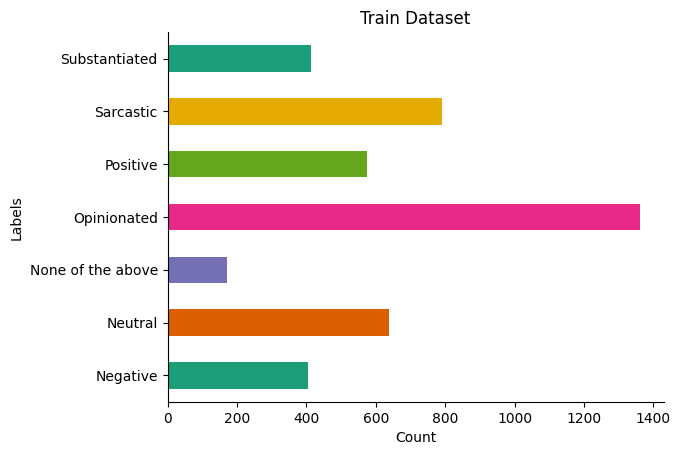

In [47]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns

train.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title("Train Dataset")
plt.xlabel("Count")
plt.ylabel("Labels")
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
test.head()

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [10]:
rep.head()

,Id,content
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ..."
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...


In [11]:
data=train.copy()
data.isnull().sum()

,0
content,0
labels,0


In [12]:
label_count=data['labels'].value_counts()
label_count

,count
labels,
Opinionated,1361
Sarcastic,790
Neutral,637
Positive,575
Substantiated,412
Negative,406
None of the above,171


In [13]:
def preprocess_tamil_text(text):
    # Step 1: Normalize Unicode
    text = re.sub(r'\u200c', '', text)

    # Step 2: Remove non-Tamil characters, special characters, and numbers
    text = re.sub(r'[^஀-௿\s]', '', text)  # Retain only Tamil script and spaces
    text = re.sub(r'\d+', '', text)  # Remove numeric values

    # Step 3: Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Step 4: Handle commonly used spoken variants (expanded replacements)
    replacements = {
        "ஏ": "எ",  # Normalize vowels
        "ஓ": "ஒ",
        "கௌ": "கோ",  # Normalize common diphthongs
        "சௌ": "சோ",
        "பௌ": "போ",
        "கெ": "கே",
        "செ": "சே",
        "டெ": "டே",
        "தெ": "தே",
        "நெ": "நே",
        "பெ": "பே",
        "மெ": "மே",
        "வெ": "வே",
        "லெ": "லே",
        "றெ": "றே",
        "னெ": "னே",
        "இ": "எ",  # Normalize short vowels
        "உ": "ஒ",
        "க்ஷ": "க",  # Normalize compound consonants
        "ஜ": "ச"
    }
    for key, value in replacements.items():
        text = text.replace(key, value)

    return text

In [14]:
def tokenize_text(text):
    doc = nlp(text)  # Tokenize the text using Stanza
    return ' '.join([word.text for word in doc.sentences[0].words])

In [15]:
data['content'] = data['content'].apply(preprocess_tamil_text)

In [16]:
data['content'] = data['content'].apply(tokenize_text)

In [17]:
data.head()

,content,labels
0,தேன்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் எதனை சூசகமாக மாதங்கள் முன்பே பேட்டியில்...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது எந்த துயரம் நேர்ந்து என...,Opinionated
3,எடப்பாடியை கண்டுகொள்ளாத எடப்பாடி ஆதரிப்பீர் ஒத...,Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்க்கும் ஆனது ம...,Opinionated


In [18]:
class_counts = data['labels'].value_counts()
max_class_size = class_counts.max()
upsampled_data = []

for label in class_counts.index:
    class_data = data[data['labels'] == label]

    # Upsample to the maximum class size
    upsampled_class_data = resample(class_data,
                                    replace=True,  # Sample with replacement
                                    n_samples=max_class_size,  # Match the size of the largest class
                                    random_state=42)

    upsampled_data.append(upsampled_class_data)

balanced_data = pd.concat(upsampled_data)

balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
null_values = balanced_data.isnull().sum()

In [19]:
balanced_data.isnull().sum()

,0
content,0
labels,0


In [20]:
balanced_data.head()

,content,labels
0,எந்த ரூ அதுவும் தேர்தல் நேரத்தில்பேண்களுக்கு ச...,Opinionated
1,தஞ்சாவூர் நாடாளுமன்றம் தொகுதி வேட்பாளர் திருசம...,Substantiated
2,சாபர் சாதிக் வழக்கில் க்கு ஒள்நோக்கம் எருக்குத...,Negative
3,நல்லா பண்ணி எருக்கிங்க,None of the above
4,தேருக்கோடியில் நின்றாலும் தனியாக தான் நிற்பேன்,Positive


In [21]:
label_counts=balanced_data["labels"].value_counts()
label_counts

,count
labels,
Opinionated,1361
Substantiated,1361
Negative,1361
None of the above,1361
Positive,1361
Neutral,1361
Sarcastic,1361


In [22]:
test_data=pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_test_without_lables.csv')
test_data.head()

,Id,content
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ..."
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...


In [23]:
test_data['content'] =test_data['content'].apply(preprocess_tamil_text)

In [24]:
test_data['content'] =test_data['content'].apply(tokenize_text)

In [25]:
pre_test_data=test_data['content']
pre_test_data

,content
0,எஸ்லாமிய சகோதர்க் உர்களன் ரமலான் கொண்டாடிய அதி...
1,ஒபிஎஸ் எடப்பாடி போட்டா போட்டி திடீரென பணிகளை ம...
2,என்றைய பரப்புரை நாம் தமிழர் கட்சி தலைமை ஒருங்க...
3,என்னும் எ நாளில் வேல்வோம் தமிழராய் தலை நிமிர்வ...
4,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பேயர...
...,...
539,அண்ணன் திருமாவின் குரலுக்கு முன்னாள் முன்னாள் ...
540,விசய் விசய்சேதுபதி விசய்ஆண்டனி தலைகீழ் மாற்றம்...
541,தமிழர்களை ஒடுக்குவதில் மட்டுமே தீவிரமாக சேயல்ப...
542,நாகபட்டினம் தொகுதி ஆண்டுகள் ஆக மக்கள் பிரதிநித...


In [26]:
balanced_data.to_csv('/content/preprocessed_PS_train.csv', index=False)

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
data = pd.read_csv('/content/preprocessed_PS_train.csv')
data

,content,labels
0,எந்த ரூ அதுவும் தேர்தல் நேரத்தில்பேண்களுக்கு ச...,Opinionated
1,தஞ்சாவூர் நாடாளுமன்றம் தொகுதி வேட்பாளர் திருசம...,Substantiated
2,சாபர் சாதிக் வழக்கில் க்கு ஒள்நோக்கம் எருக்குத...,Negative
3,நல்லா பண்ணி எருக்கிங்க,None of the above
4,தேருக்கோடியில் நின்றாலும் தனியாக தான் நிற்பேன்,Positive
...,...,...
9522,தமிழ்நாடு அரசு கோரிய டிஎம்சி நீரை தர முடியாது ...,Substantiated
9523,நடிகர் விசய் சீமானுக்கு ஆதரவு தேரித்தார் என சொ...,Positive
9524,தம்பி திருப்பூர் சுடலையின் சிறப்பான பேச்சு,Positive
9525,ஆந்திர முதல்வர் மீது கல்வீச்சு முகஸ்டாலின் கண்...,Opinionated


In [29]:
# Split dataset into features (X) and labels (y)
X = data['content']
y = data['labels']

In [30]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vectorized, y_train)

# Predictions
y_pred_train = rf_model.predict(X_train_vectorized)
y_pred_test = rf_model.predict(X_test_vectorized)

# Evaluation
print("Train Data Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

print("\nTest Data Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Train Data Evaluation:
Accuracy: 0.9493504789397716
Classification Report:
                    precision    recall  f1-score   support

         Negative       0.93      0.97      0.95      1089
          Neutral       0.93      0.92      0.93      1089
None of the above       0.94      0.99      0.96      1089
      Opinionated       0.99      0.93      0.96      1088
         Positive       0.94      0.95      0.95      1089
        Sarcastic       0.98      0.95      0.96      1089
    Substantiated       0.93      0.95      0.94      1088

         accuracy                           0.95      7621
        macro avg       0.95      0.95      0.95      7621
     weighted avg       0.95      0.95      0.95      7621

Confusion Matrix:
 [[1052    3    8    0    5    0   21]
 [  12 1001   18    5   22    6   25]
 [   0    8 1073    0    0    4    4]
 [  14   30   12 1011   15    2    4]
 [  17   11   12    3 1034    3    9]
 [  20    9   10    3    7 1030   10]
 [  13   13    9    0   1

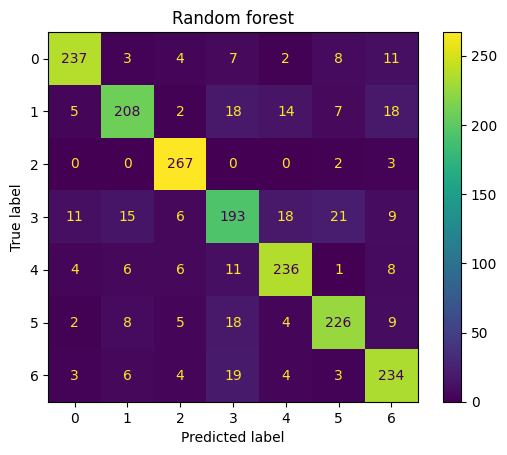

In [34]:
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.title("Random forest")
plt.show()

In [35]:
import pandas as pd

# Load test dataset
test_data=pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_test_without_lables.csv')
# Preprocess test data (if needed, skip this if already preprocessed)
#test_data['content'] = test_data['content'].apply(preprocess_tamil_text)

# Vectorize the test dataset
X_test_vectorized = vectorizer.transform(pre_test_data)

# Make predictions
predictions = rf_model.predict(X_test_vectorized)

# Add predictions to the test dataset
test_data['Labels'] = predictions

# Save the results to a CSV file
output_file = "Beyond_tech_Tamil_run1.csv"
test_data.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


Predictions saved to Beyond_tech_Tamil_run1.csv


In [36]:
test_pred_data = pd.read_csv("/content/Beyond_tech_Tamil_run1.csv")
test_pred_data

,Id,content,Labels
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,Sarcastic
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,Sarcastic
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,Opinionated
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",Substantiated
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,Positive
...,...,...,...
539,PS_540,அண்ணன் திருமாவின் குரலுக்கு முன்னாள் முன்னாள் ...,Positive
540,PS_541,#விஜய் 🔥 #விஜய்சேதுபதி 🔥 #விஜய்ஆண்டனி\n\nதலைகீ...,Sarcastic
541,PS_542,தமிழர்களை ஒடுக்குவதில் மட்டுமே தீவிரமாக செயல்ப...,Negative
542,PS_543,நாகபட்டினம் தொகுதி MP 20 ஆண்டுகளாக மக்கள் பிரத...,Positive


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert sparse matrices to dense NumPy arrays
X_train_vectorized = X_train_vectorized.toarray()  # Convert to dense array
X_test_vectorized = X_test_vectorized.toarray()    # Convert to dense array

# Encode labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Neural Network model
model = Sequential()
model.add(Dense(512, input_dim=X_train_vectorized.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(set(y_train_encoded)), activation='softmax'))  # Number of output classes

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using encoded labels
model.fit(X_train_vectorized, y_train_encoded, epochs=30, batch_size=128, validation_data=(X_test_vectorized, y_test_encoded))

# Predictions (use encoded labels for evaluation)
y_pred_train = model.predict(X_train_vectorized)
y_pred_train_classes = y_pred_train.argmax(axis=1)

y_pred_test = model.predict(X_test_vectorized)
y_pred_test_classes = y_pred_test.argmax(axis=1)

# Evaluation (use encoded labels for evaluation)
print("Train Data Evaluation:")
print("Accuracy:", accuracy_score(y_train_encoded, y_pred_train_classes))
print("Classification Report:\n", classification_report(y_train_encoded, y_pred_train_classes))
print("Confusion Matrix:\n", confusion_matrix(y_train_encoded, y_pred_train_classes))

print("\nTest Data Evaluation:")
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_test_classes))
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_test_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_test_classes))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.1981 - loss: 1.9071 - val_accuracy: 0.3657 - val_loss: 1.5761
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4510 - loss: 1.4560 - val_accuracy: 0.5530 - val_loss: 1.2000
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 1.0407 - val_accuracy: 0.6737 - val_loss: 0.9576
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7513 - loss: 0.7394 - val_accuracy: 0.7356 - val_loss: 0.8060
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8043 - loss: 0.5677 - val_accuracy: 0.7545 - val_loss: 0.7345
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.4411 - val_accuracy: 0.7996 - val_loss: 0.6747
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8715 - loss: 0.3892 - val_accuracy: 0.8153 - val_loss: 0.6347
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8939 - loss: 0.3285 - val_accuracy: 0.8153 - val_loss

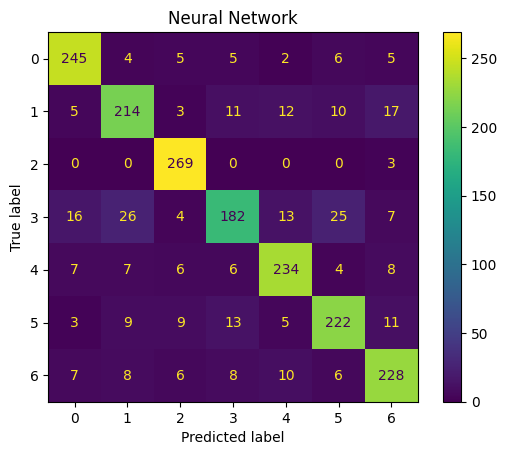

In [44]:
from sklearn import metrics
cm1 = metrics.confusion_matrix(y_test_encoded, y_pred_test_classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1)

cm_display.plot()
plt.title("Neural Network")
plt.show()

In [43]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the test dataset
test_data = pd.read_csv('/content/drive/MyDrive/Beyond Tech/Sentiment Analysis of Tamil/PS_test_without_lables.csv')

# Preprocess test data (if needed, apply the same preprocessing steps used for training)
# test_data['content'] = test_data['content'].apply(preprocess_tamil_text)

# Vectorize the test dataset using the same vectorizer used during training
# Here, we assume `vectorizer` was fitted on the training data, and we are using it for the test data
X_test_vectorized = vectorizer.transform(pre_test_data)

# Convert sparse matrix to dense array (same as you did during training)
X_test_vectorized = X_test_vectorized.toarray()

# Predict the labels using the trained neural network model
predictions = model.predict(X_test_vectorized)

# Convert the prediction probabilities to class labels
predicted_classes = predictions.argmax(axis=1)  # Get the index of the class with the highest probability

# Decode the predicted class labels back to the original labels using LabelEncoder
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Add the predicted labels to the test dataset
test_data['Labels'] = predicted_labels

# Save the results to a new CSV file
output_file = "Beyond_tech_Tamil_run2.csv"
test_data.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predictions saved to Beyond_tech_Tamil_run2.csv
